## Table of Contents
<a id='contents'></a>

[Python working setup](#pySetup)

[Species accumulation curves](#SAC)

[Turnover diagrams by habitat](#Turnover)

[Ordination by habitat](#NMS)

[PERMANOVA models of available environmental data](#PERMANOVA)  

[hierarchical clustering of sites](#hierarch)

[Physical Map](#DEGmap)

[Indicator species analysis](#indSpp)

[Mantel tests](#mantel)


<a id='pySetup'></a>
### Python working setup

In [1]:
import os
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
import scipy.spatial as sp
import geopandas as gpd
import rasterio
import rasterio.plot
import copy
import random

I did a bit of data cleaning of Ana's raw data, to create the following working dataframe. It has most of what I need up to this point:

In [5]:
specObs = pd.read_pickle('specObs.p')
specObs.head()

,site,parcela,subparcela,PsubP,familia,genero,especie,genusSpecies,habito,elevacion,habitat
1,1,1,1,1.1,Flacourtiaceae,Banara,regia,Flacourtiaceae Banara regia,Árbol,1425,RG
2,1,1,1,1.1,Melastomataceae,Leandra,subseriata,Melastomataceae Leandra subseriata,Arbolito,1413,RG
3,1,1,1,1.1,Melastomataceae,Ossaea,micrantha,Melastomataceae Ossaea micrantha,Arbolito,1413,RG
4,1,1,1,1.1,Melastomataceae,Ossaea,micrantha,Melastomataceae Ossaea micrantha,Arbolito,1413,RG
5,1,1,1,1.1,Cecropiaceae,Cecropia,reticulata,Cecropiaceae Cecropia reticulata,Árbol,1413,RG


For all of the analyses conducted so far, I have used the subplot as a basic sampling unit. These are denoted in the PsubP column, where the first number is the plot, and the number after the decimal is a subplot. Together they make a unique identifier. 

From this we can make a general site x species matrix:

In [15]:
smallSpecObs = specObs[['PsubP','genusSpecies']]
bdfDummy = pd.get_dummies(smallSpecObs['genusSpecies'])
bdfDummy.insert(0, 'PsubP', smallSpecObs.PsubP)
bdfDummyGroup = bdfDummy.groupby('PsubP')
subParcelComm = bdfDummyGroup.agg(np.sum)
subParcelComm.head()

,Actinidaceae Saurauia sp. 1,Anacardiaceae Mauria cf. heterophylla,Anacardiaceae Tapirira guianensis,Annonaceae Guatteria cf. megalophylla,Annonaceae Guatteria megalophylla,Annonaceae Guatteria sp.,Annonaceae Rollinia aff. dolichopetala,Annonaceae Rollinia edulis,Annonaceae sp.,Aquifoliaceae Ilex cf. yurumanguinis,...,Theophrastaceae Clavija eggersiana,Theophrastaceae Clavija membranacea,Thymelaeaceae Schoenobiblus daphnoides,Ulmaceae Trema micrantha,Urticaceae Boehmeria caudata,Urticaceae Urera aff. caracasana,Urticaceae Urera baccifera,Urticaceae Urera caracasana,Verbenaceae Aegiphila alba,Violaceae Gloeospermum longifolium
PsubP,,,,,,,,,,,,,,,,,,,,,
1.1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Exploring our data a bit:

In [8]:
specObs.columns

Index(['site', 'parcela', 'subparcela', 'PsubP', 'familia', 'genero',
       'especie', 'genusSpecies', 'habito', 'elevacion', 'habitat'],
      dtype='object')

In [6]:
specObs.shape

(2737, 11)

2737 observations, each one representing a collection of a plant. Lots of plants. How many species observed?

In [10]:
len(specObs.genusSpecies.unique())

343

[back to top](#contents)

<a id="SAC"></a>
### Species accumulation curves

We can split up our site-by-species matrix by habitat, in python:

aa = specObs[['PsubP', 'habitat']].drop_duplicates()
aa.set_index('PsubP', inplace=True)
bb = pd.concat([aa, subParcelComm], axis=1)
bbGrouped = bb.groupby('habitat')
habs = list(bbGrouped.groups.keys())

for i in habs:
    cc = bbGrouped.get_group(i)
    observed = (cc != 0).any(axis=0).values
    dd = cc.iloc[:,observed]
    dd.drop('habitat', axis=1, inplace=True)
    dd.to_csv(f'{i}_comm.csv')

Now we can use these smaller dataframes to make turnover graphs and do chao estimates. Back to R:

In [4]:
library(vegan)
library(RColorBrewer)
library(repr)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



[1] "subParcelComm.csv"
[1] "BC_comm.csv"
[1] "BS_comm.csv"
[1] "CLB_comm.csv"
[1] "RCA_comm.csv"


Warning message in cor(x > 0):
“the standard deviation is zero”


[1] "RG_comm.csv"


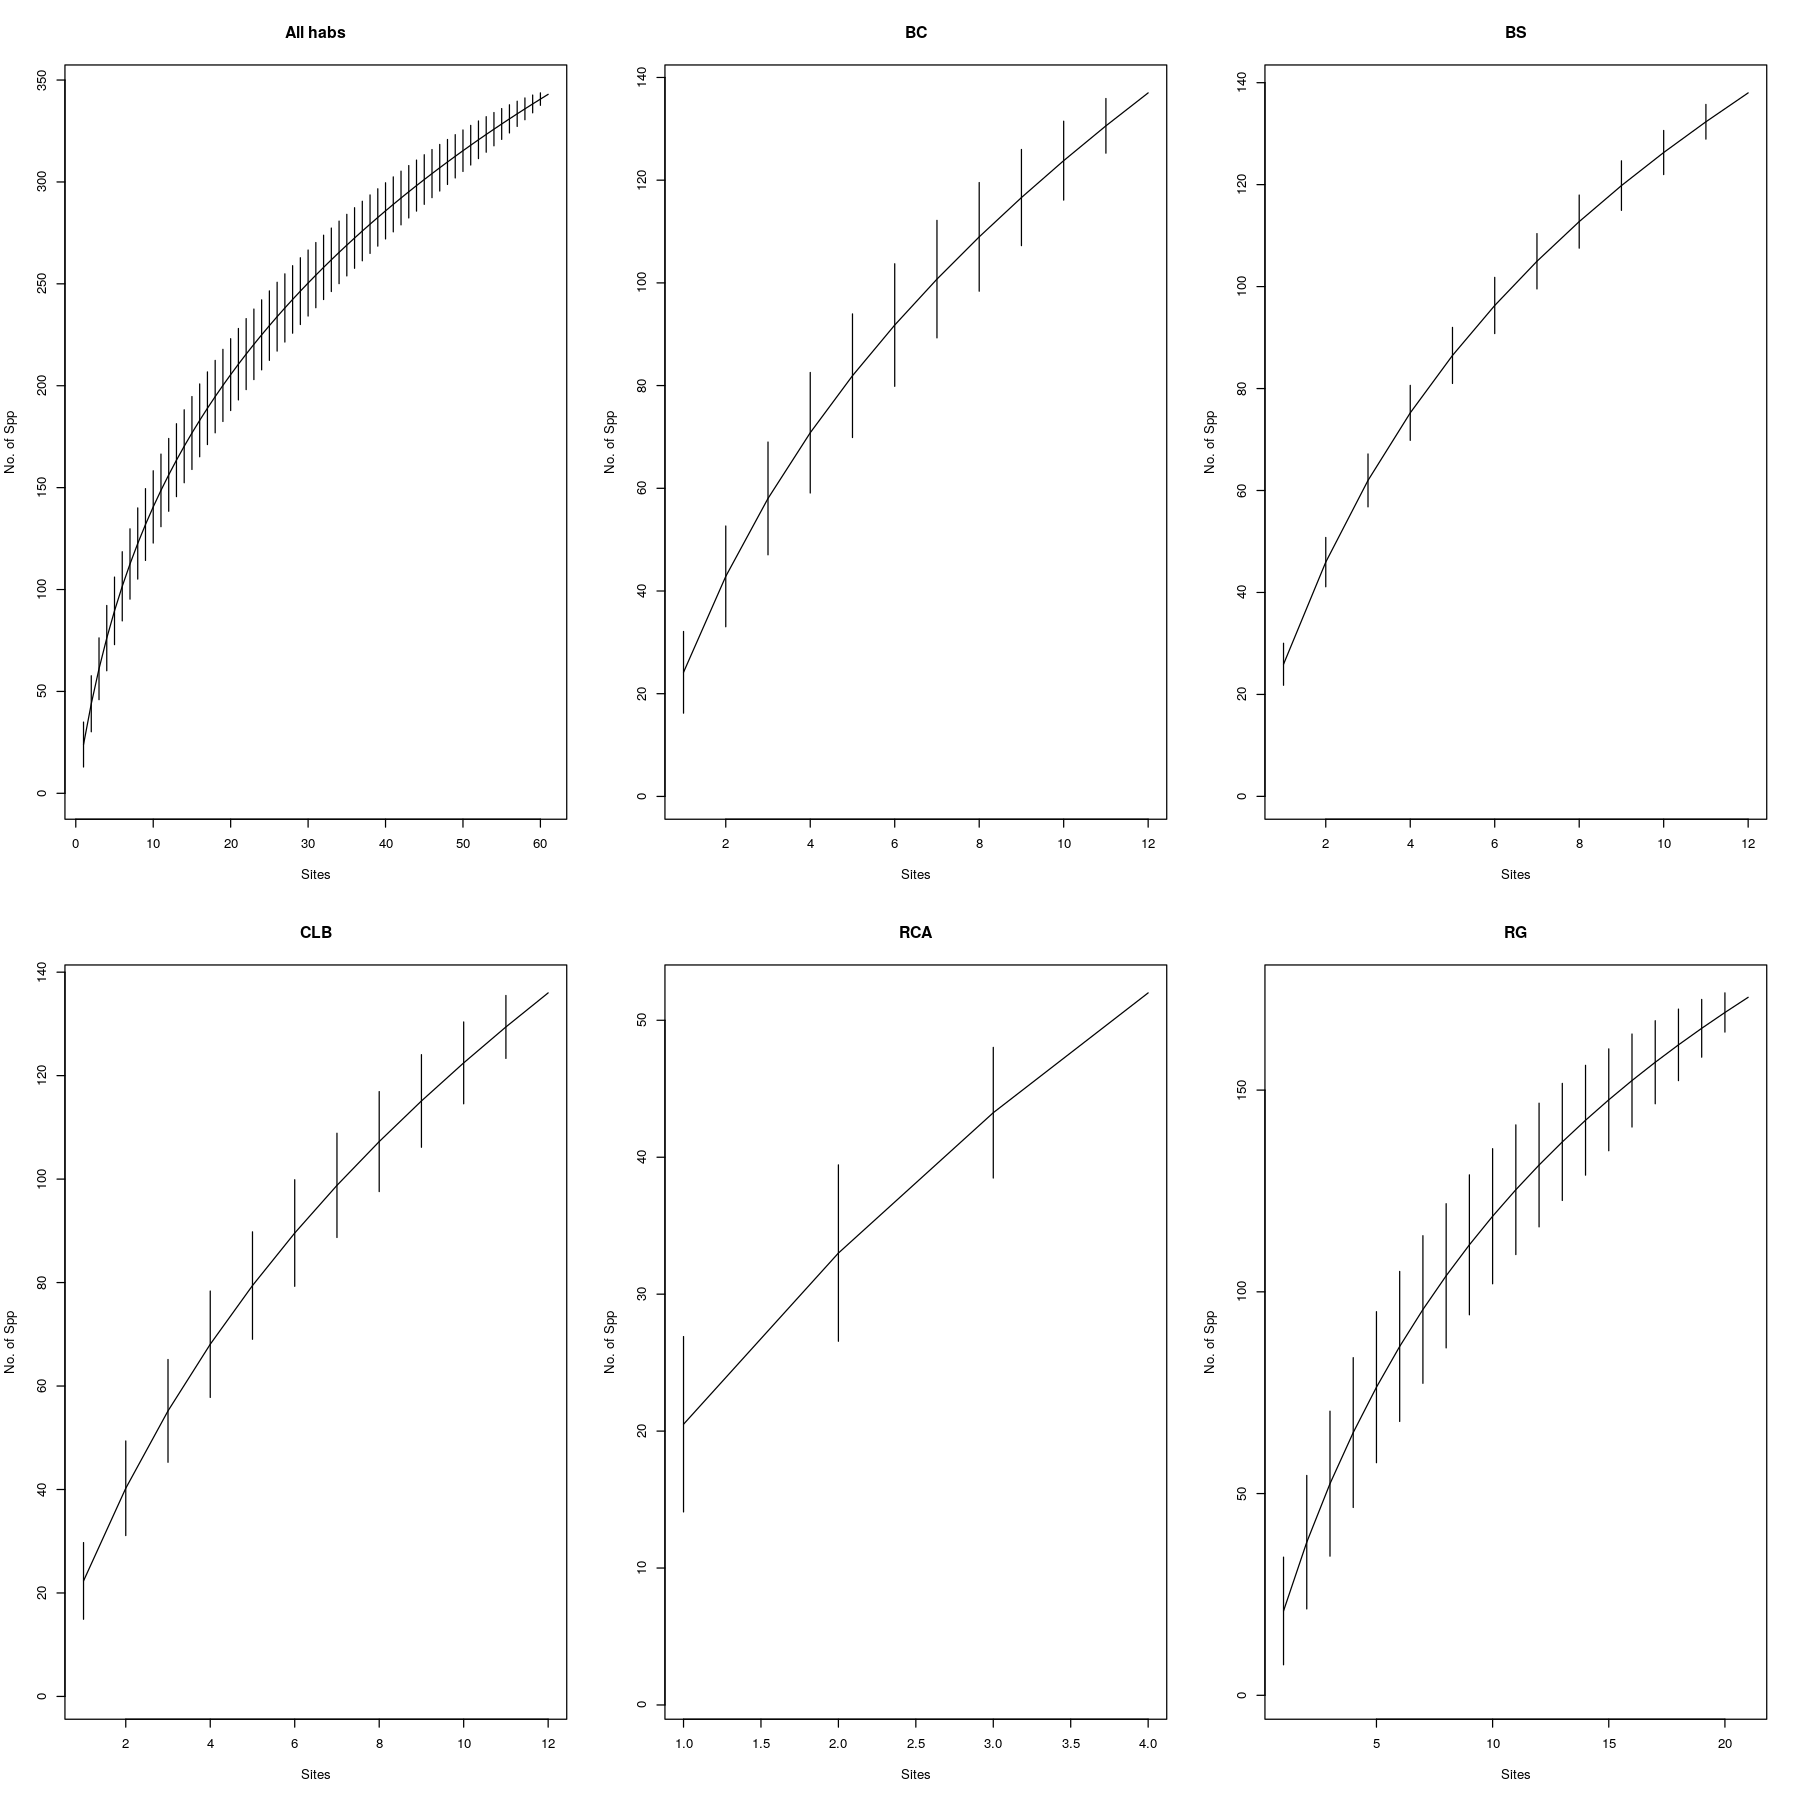

In [7]:
options(repr.plot.width=15, repr.plot.height=15)
par(mfrow = c(2,3))
files <- list.files()
comm <- grep('_comm.csv', list.files())
comms <- files[comm]
comms <- c("subParcelComm.csv", comms)
comtitles <- sub("_comm.csv", "", comms)
comtitles[1] <- "All habs"
j <- 0
for (i in comms){
    j <- j + 1
    comm.i <- read.csv(i, header=TRUE, row.names=1)
    print(i)
    SAC <- specaccum(comm.i, method = "exact")
    plot(SAC, main=comtitles[j], ylab='No. of Spp')
    capture.output(print(paste('Species estimates for', comtitles[j], sep=" ")),
                    file="habSRestimates.txt", append = TRUE)
    capture.output(specpool(comm.i),
                    file="habSRestimates.txt",
                    append = TRUE)
    sacDF <- data.frame(cbind(SAC$richness, SAC$sd), row.names=SAC$sites)
    colnames(sacDF) <- c('richness', 'sd')
    write.csv(sacDF, file=paste(comtitles[j], "SAC.csv", sep="_"))
}

Chao estimators for these:

[back to top](#contents)

<a id='Turnover'></a>
### Turnover diagrams by habitat

Let's check turnover rates in these various habitat types:

BC


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


BS


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CLB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RCA


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RG


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


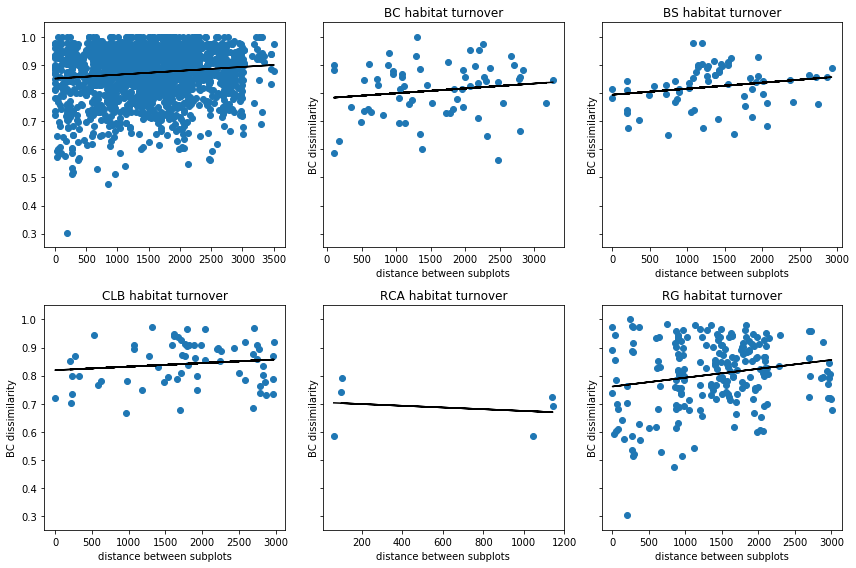

In [10]:
specObs = pd.read_pickle('specObs.p')
spDF = pd.read_pickle('subParcelSpatial.p')
subParcelComm = pd.read_pickle("subParcelComm.p")

## get our original in there first:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12,8))
axes = axes.flatten()

physDist = sp.distance.pdist(spDF, metric='euclidean')
bcDist = sp.distance.pdist(subParcelComm, metric='brayCurtis')
X, Y = physDist.reshape(-1,1), bcDist.reshape(-1,1)
axes[0].scatter(physDist, bcDist)
axes[0].plot( X, LinearRegression().fit(X, Y).predict(X), c='k')

soGrouped = specObs.groupby('habitat')
habs = list(soGrouped.groups.keys())

for h,i in enumerate(habs):
    print(i)
    obs_i = soGrouped.get_group(i)
    obs_iN = [ spDF.loc[a].N for a in obs_i.PsubP ]
    obs_iE = [ spDF.loc[a].E for a in obs_i.PsubP ]
    obs_i['N'] = obs_iN
    obs_i['E'] = obs_iE
    subParcelInObs_i = subParcelComm.index.isin(obs_i.PsubP)
    comm_i = subParcelComm[subParcelInObs_i]
    notObserved=~((comm_i == 0).all(axis=0).values)
    comm_i = comm_i.iloc[:,notObserved]
    spDF_i = spDF.loc[comm_i.index.values]
    physDist_i = sp.distance.pdist(spDF_i, metric='euclidean')
    bcDist_i = sp.distance.pdist(comm_i, metric='brayCurtis')
    axes[h+1].scatter(physDist_i, bcDist_i)
    X, Y = physDist_i.reshape(-1,1), bcDist_i.reshape(-1,1)
    axes[h+1].plot( X, LinearRegression().fit(X, Y).predict(X), c='k')
    axes[h+1].set_xlabel('distance between subplots')
    axes[h+1].set_ylabel('BC dissimilarity')
    axes[h+1].set_title(f'{i} habitat turnover')
    
    plt.tight_layout()

[back to top](#contents)

<a id='NMS'></a>
### Ordination by habitat

Let's see how these habitats separate out, if at all. We'll need to do this in R.

In [27]:
library(vegan)
library(RColorBrewer)

In [28]:
subParcelComm <- read.csv('subParcelComm.csv', header=TRUE)
sPC <- subParcelComm[,-1]
rownames(sPC) <- subParcelComm[,1]

In [29]:
nms <- metaMDS(sPC, try=40)

Wisconsin double standardization
Run 0 stress 0.2882666 
Run 1 stress 0.3195477 
Run 2 stress 0.2947891 
Run 3 stress 0.2892106 
Run 4 stress 0.292469 
Run 5 stress 0.3178613 
Run 6 stress 0.2936669 
Run 7 stress 0.2897919 
Run 8 stress 0.2892864 
Run 9 stress 0.3106905 
Run 10 stress 0.2951552 
Run 11 stress 0.2897904 
Run 12 stress 0.2909597 
Run 13 stress 0.2897151 
Run 14 stress 0.2882719 
... Procrustes: rmse 0.00530008  max resid 0.02712079 
Run 15 stress 0.2896714 
Run 16 stress 0.2927371 
Run 17 stress 0.2905834 
Run 18 stress 0.2883975 
... Procrustes: rmse 0.01098062  max resid 0.04810461 
Run 19 stress 0.2909603 
Run 20 stress 0.2927886 
Run 21 stress 0.2920623 
Run 22 stress 0.2935624 
Run 23 stress 0.2896132 
Run 24 stress 0.2932293 
Run 25 stress 0.2921688 
Run 26 stress 0.2896941 
Run 27 stress 0.2896659 
Run 28 stress 0.2912579 
Run 29 stress 0.2909597 
Run 30 stress 0.2897274 
Run 31 stress 0.2896175 
Run 32 stress 0.2923796 
Run 33 stress 0.293559 
Run 34 stress 0.288

Stresses look high...check them out a little more closely:

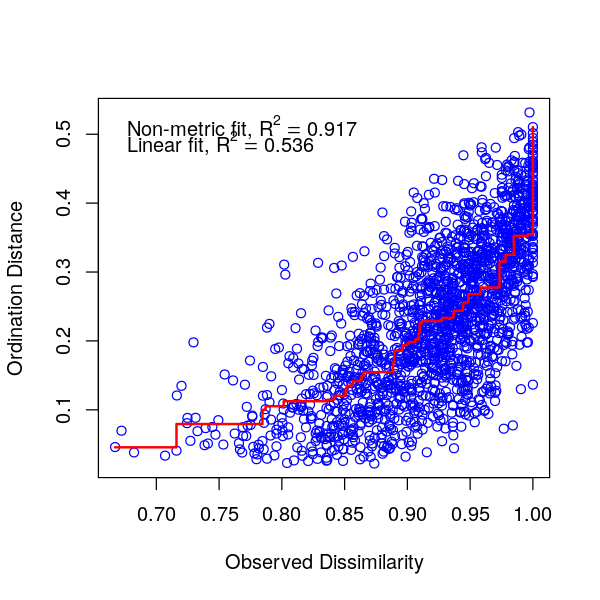

In [32]:
options(repr.plot.width=5, repr.plot.height=5)
stressplot(nms)


Not great, but might be useful. Most of the solutions are under 0.3...let's look at the one that was saved:

In [33]:
specObs <- read.csv('specObs.csv')
aa = specObs[c("PsubP","habitat")]
colrs <- brewer.pal(5, "Set1")
nondups <- aa[!duplicated(aa),]
nondups <- nondups[order(nondups$PsubP),]
rownames(nondups) <- NULL
nondups$colorNu <- as.numeric(nondups$habitat)
nondups$colrs <- colrs[nondups$colorNu]
nondups$MDS1 <- nms$points[,'MDS1']
nondups$MDS2 <- nms$points[,'MDS2']
nmsInfo <- nondups

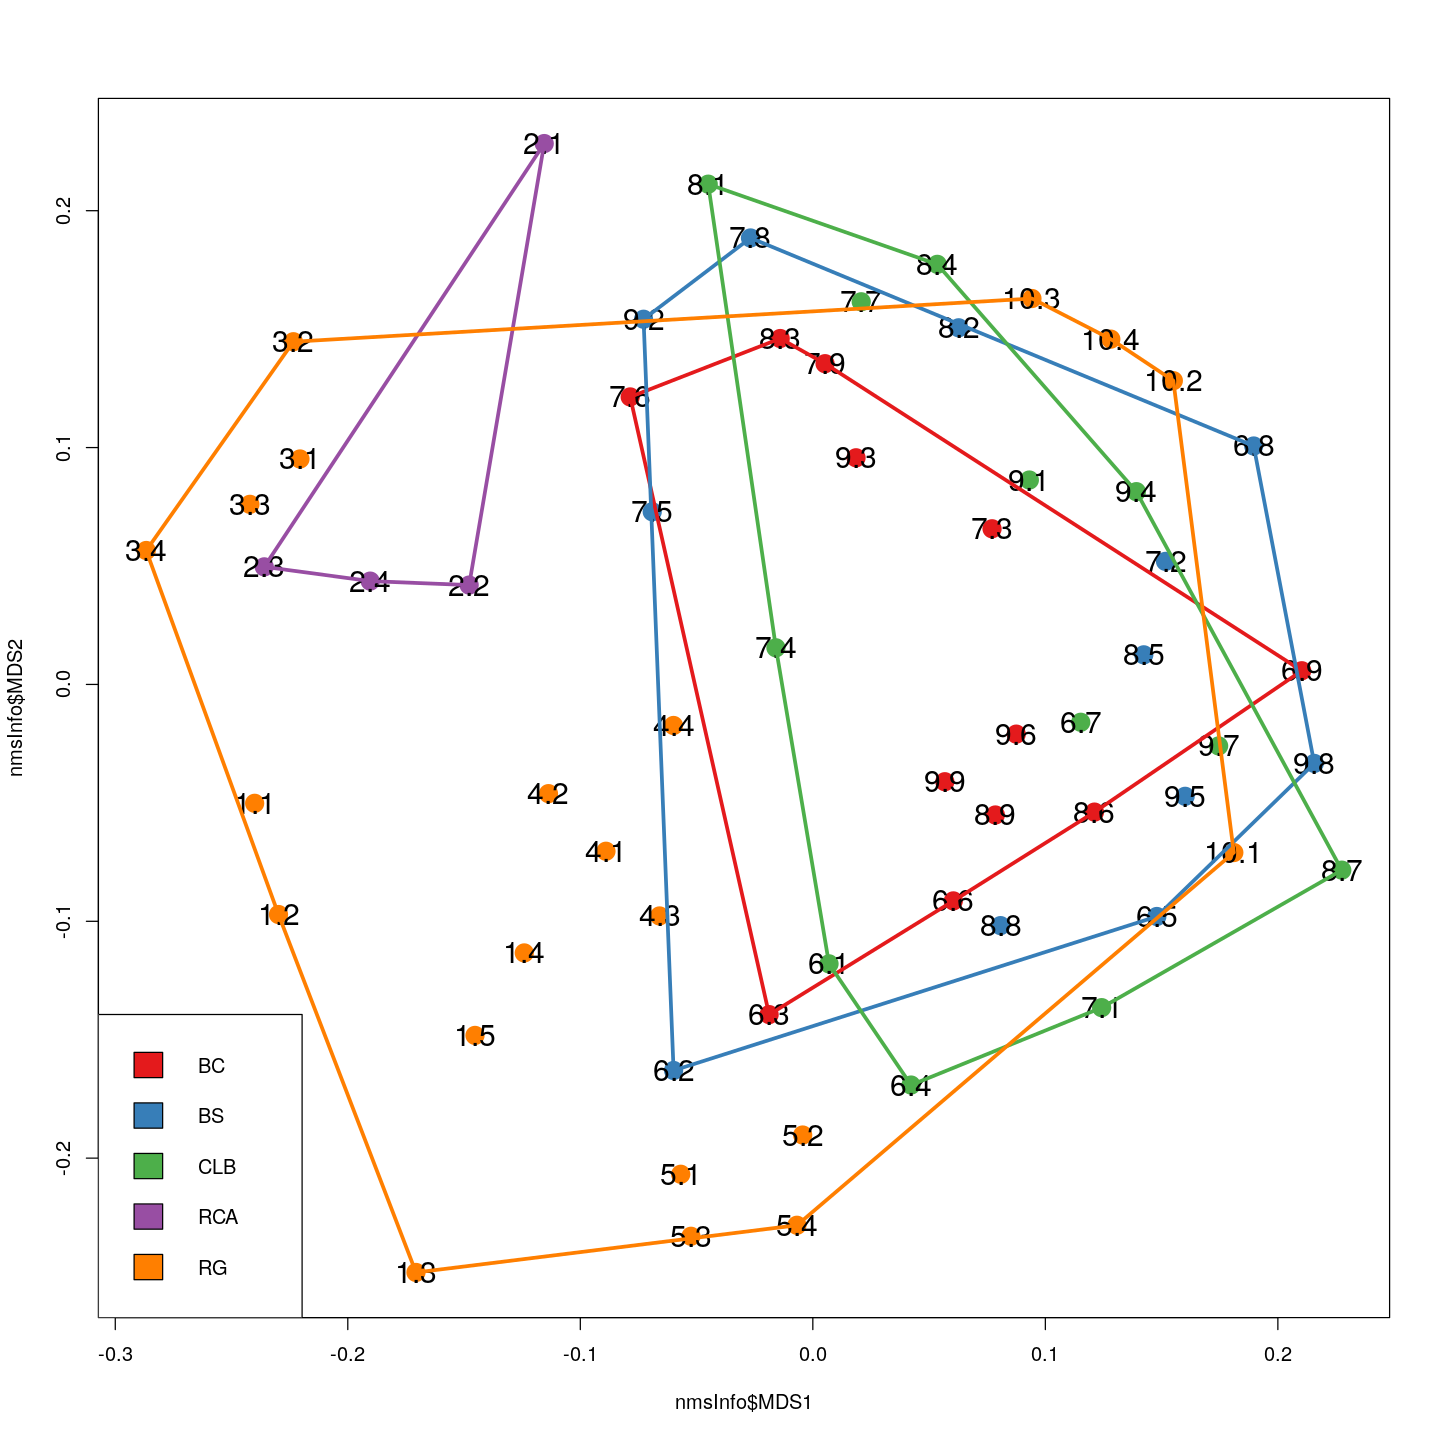

In [40]:
options(repr.plot.width=12, repr.plot.height=12)
plot(nmsInfo$MDS1, nmsInfo$MDS2,
    col=nmsInfo$colrs,
    pch=19,
    cex=2.0,
)
text(nmsInfo$MDS1, nmsInfo$MDS2, nmsInfo$PsubP, cex=1.5)
## add a legend
legend( x='bottomleft',
        legend = c('BC', 'BS', 'CLB', 'RCA', 'RG'),
        fill = c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'),
        col = c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'),
        cex = 1.0,
        )
ordihull(nms, nmsInfo$habitat, col=c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'), lwd=3)


BC - Bosque cerrado  
BS - Bosque secundario  
CLB - Claro de bosque  
RG - regeneración fincas agricultura ganadería  
RCA - Regeneración cañaveral  

<a id='PERMANOVA'></a>

### PERMANOVA models of available environmental data

Let's look at the influence of elevation and habitat type on our dissimilarity matrix. For the moment, the only directly observed data I have is habitat type (RCA, RG, CLB, etc), and elevation. 

In [44]:
library(vegan)

envOnly <- read.csv('envOnly.csv')
envOnly <- envOnly[order(envOnly$PsubP),]

subParcelComm <- read.csv('subParcelComm.csv', header=TRUE)
sPC <- subParcelComm[,-1]
rownames(sPC) <- subParcelComm[,1]
sPC <- sPC[order(as.numeric(rownames(sPC))),]

adonis(sPC ~ envOnly$elevacion*envOnly$habitat)


Call:
adonis(formula = sPC ~ envOnly$elevacion * envOnly$habitat) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                                  Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
envOnly$elevacion                  1    1.8357 1.83572  5.9572 0.07945  0.001
envOnly$habitat                    4    4.1072 1.02679  3.3321 0.17776  0.001
envOnly$elevacion:envOnly$habitat  4    1.4468 0.36170  1.1738 0.06262  0.116
Residuals                         51   15.7157 0.30815         0.68017       
Total                             60   23.1054                 1.00000       
                                     
envOnly$elevacion                 ***
envOnly$habitat                   ***
envOnly$elevacion:envOnly$habitat    
Residuals                            
Total                                
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Habitat type is having a strong influence here, and elevation is having a lesser but statistically significant effect. There doesn't seem to be a ton of interaction there, or at least the story is too noisy to be statistically significant. If we reverse the terms (habitat and elevation, not shown) we get similar results. 

Just checking, is the story clearer if we subset to just old forest?:

In [50]:
## just old forest, with no zero columns
oldF <- envOnly$habitat != 'RG' & envOnly$habitat != 'RCA'
oldForestEnv <-  envOnly[oldF,]
oldForestComm <- sPC[oldF,]
all(rownames(sPC) == envOnly$PsubP )
nonzs <- colSums(oldForestComm) != 0
oldForestComm <- oldForestComm[,nonzs]

## run test
bb <- adonis(oldForestComm ~ oldForestEnv$elevacion*oldForestEnv$habitat)  
bb

[1] TRUE


Call:
adonis(formula = oldForestComm ~ oldForestEnv$elevacion * oldForestEnv$habitat) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                                            Df SumsOfSqs MeanSqs F.Model
oldForestEnv$elevacion                       1    1.5845 1.58450  5.2158
oldForestEnv$habitat                         2    0.6300 0.31502  1.0369
oldForestEnv$elevacion:oldForestEnv$habitat  2    0.6416 0.32079  1.0560
Residuals                                   30    9.1137 0.30379        
Total                                       35   11.9698                
                                                 R2 Pr(>F)    
oldForestEnv$elevacion                      0.13237  0.001 ***
oldForestEnv$habitat                        0.05263  0.356    
oldForestEnv$elevacion:oldForestEnv$habitat 0.05360  0.316    
Residuals                                   0.76139           
Total                                       1.00000           
---
Si

If we subset to just the old forest sites (CLB, BS, BC), the permanova test cannot distinguish among habitat types. This makes sense, from the ordination above and the clustering results, there doesn't seem to be a large difference between gaps, closed forest, and recently regenerated gaps, given a constant elevation. They can almost be treated as the same habitat ("old forest"), as far as species composition. But within the old forest, elevation appears to be playing an important role. 

This begs the question, what is driving the separation of the old forest into two groups, as per our clustering results?

<a id="hierarch"></a>
### Hierarchical clustering of sites
    
Let's see if this clustering we see in the NMS is noticeable with a hierarchical clustering method, as another way of tracking similarities among sites in species composition.

In [20]:
library(stats)
library(vegan)

subParcelComm <- read.csv('subParcelComm.csv', header=TRUE)
sPC <- subParcelComm[,-1]
rownames(sPC) <- subParcelComm[,1]
## we need a distance matrix, BC
## does vegan give us what we need?
sPCBray <- vegdist(sPC)
sPC.ward <- hclust(sPCBray, method='ward.D2')

In [21]:
makeClustMap <- function(tree, k, labels=NULL, jit=50){
    envOnly <- read.csv('envOnly.csv')
    pts <- read.csv('subParcelSpatial.csv')
    require(stats)
    ## get habitat type labels for tree
    if (is.null(labels)){lab <- NULL}
    else { 
        if (labels=='hab'){
        lab <- vector(length = length(tree$labels))
        for (i in 1:length(tree$labels)){
            ind <- which(envOnly$PsubP==tree$labels[i])
            lab[i] <- as.character(envOnly$habitat[ind])
    }}}
    par(mfrow=c(2,1))
    plot(tree, labels=lab)
    clustGroups <- rect.hclust(tree, k=k, border=1:k)
    cmem <- vector(length=k)
    PsubP <- vector()
    gr <- vector()
    for (i in 1:k){
        cmem.i <- as.numeric(attr(clustGroups[[i]], "names"))
        PsubP <- c(PsubP, cmem.i)
        gr <- c(gr, rep(i, length(cmem.i)))
        }
    cGroup <- data.frame(cbind(PsubP, gr))
    cGroup <- cGroup[order(cGroup$PsubP),]
    pts <- pts[order(pts$PsubP),]
    clsp <- base::merge(pts, cGroup)
    clsp <- base::merge(clsp, envOnly)
    shapes <- vector(length=nrow(clsp))
    shapes[clsp$habitat == 'BC'] <- 19
    shapes[clsp$habitat == 'BS'] <- 21
    shapes[clsp$habitat == 'CLB'] <- 22
    shapes[clsp$habitat == 'RCA'] <- 17
    shapes[clsp$habitat == 'RG'] <- 23
    eJit=jitter(clsp$E, jit)
    nJit=jitter(clsp$N, jit)
    plot(x=eJit,
        y=nJit,
        col=clsp$gr,
        xlab='',
        ylab='',
        xlim=c(745000,749000),
        asp=1,
        cex=2,
        lwd=2,
        pch=shapes,
    )
    #legend('bottomright',
    #    legend=c('BC', 'BS', 'CLB', 'RCA', 'RG'),
    #    pch=c(19, 21, 22, 17, 23)
    #)
    #legend('bottomleft',
    #    legend=1:k,
    #    pch=c(15),
    #    col=1:k,
    #    title='ClusterGroup')
    #return(clsp)
    }


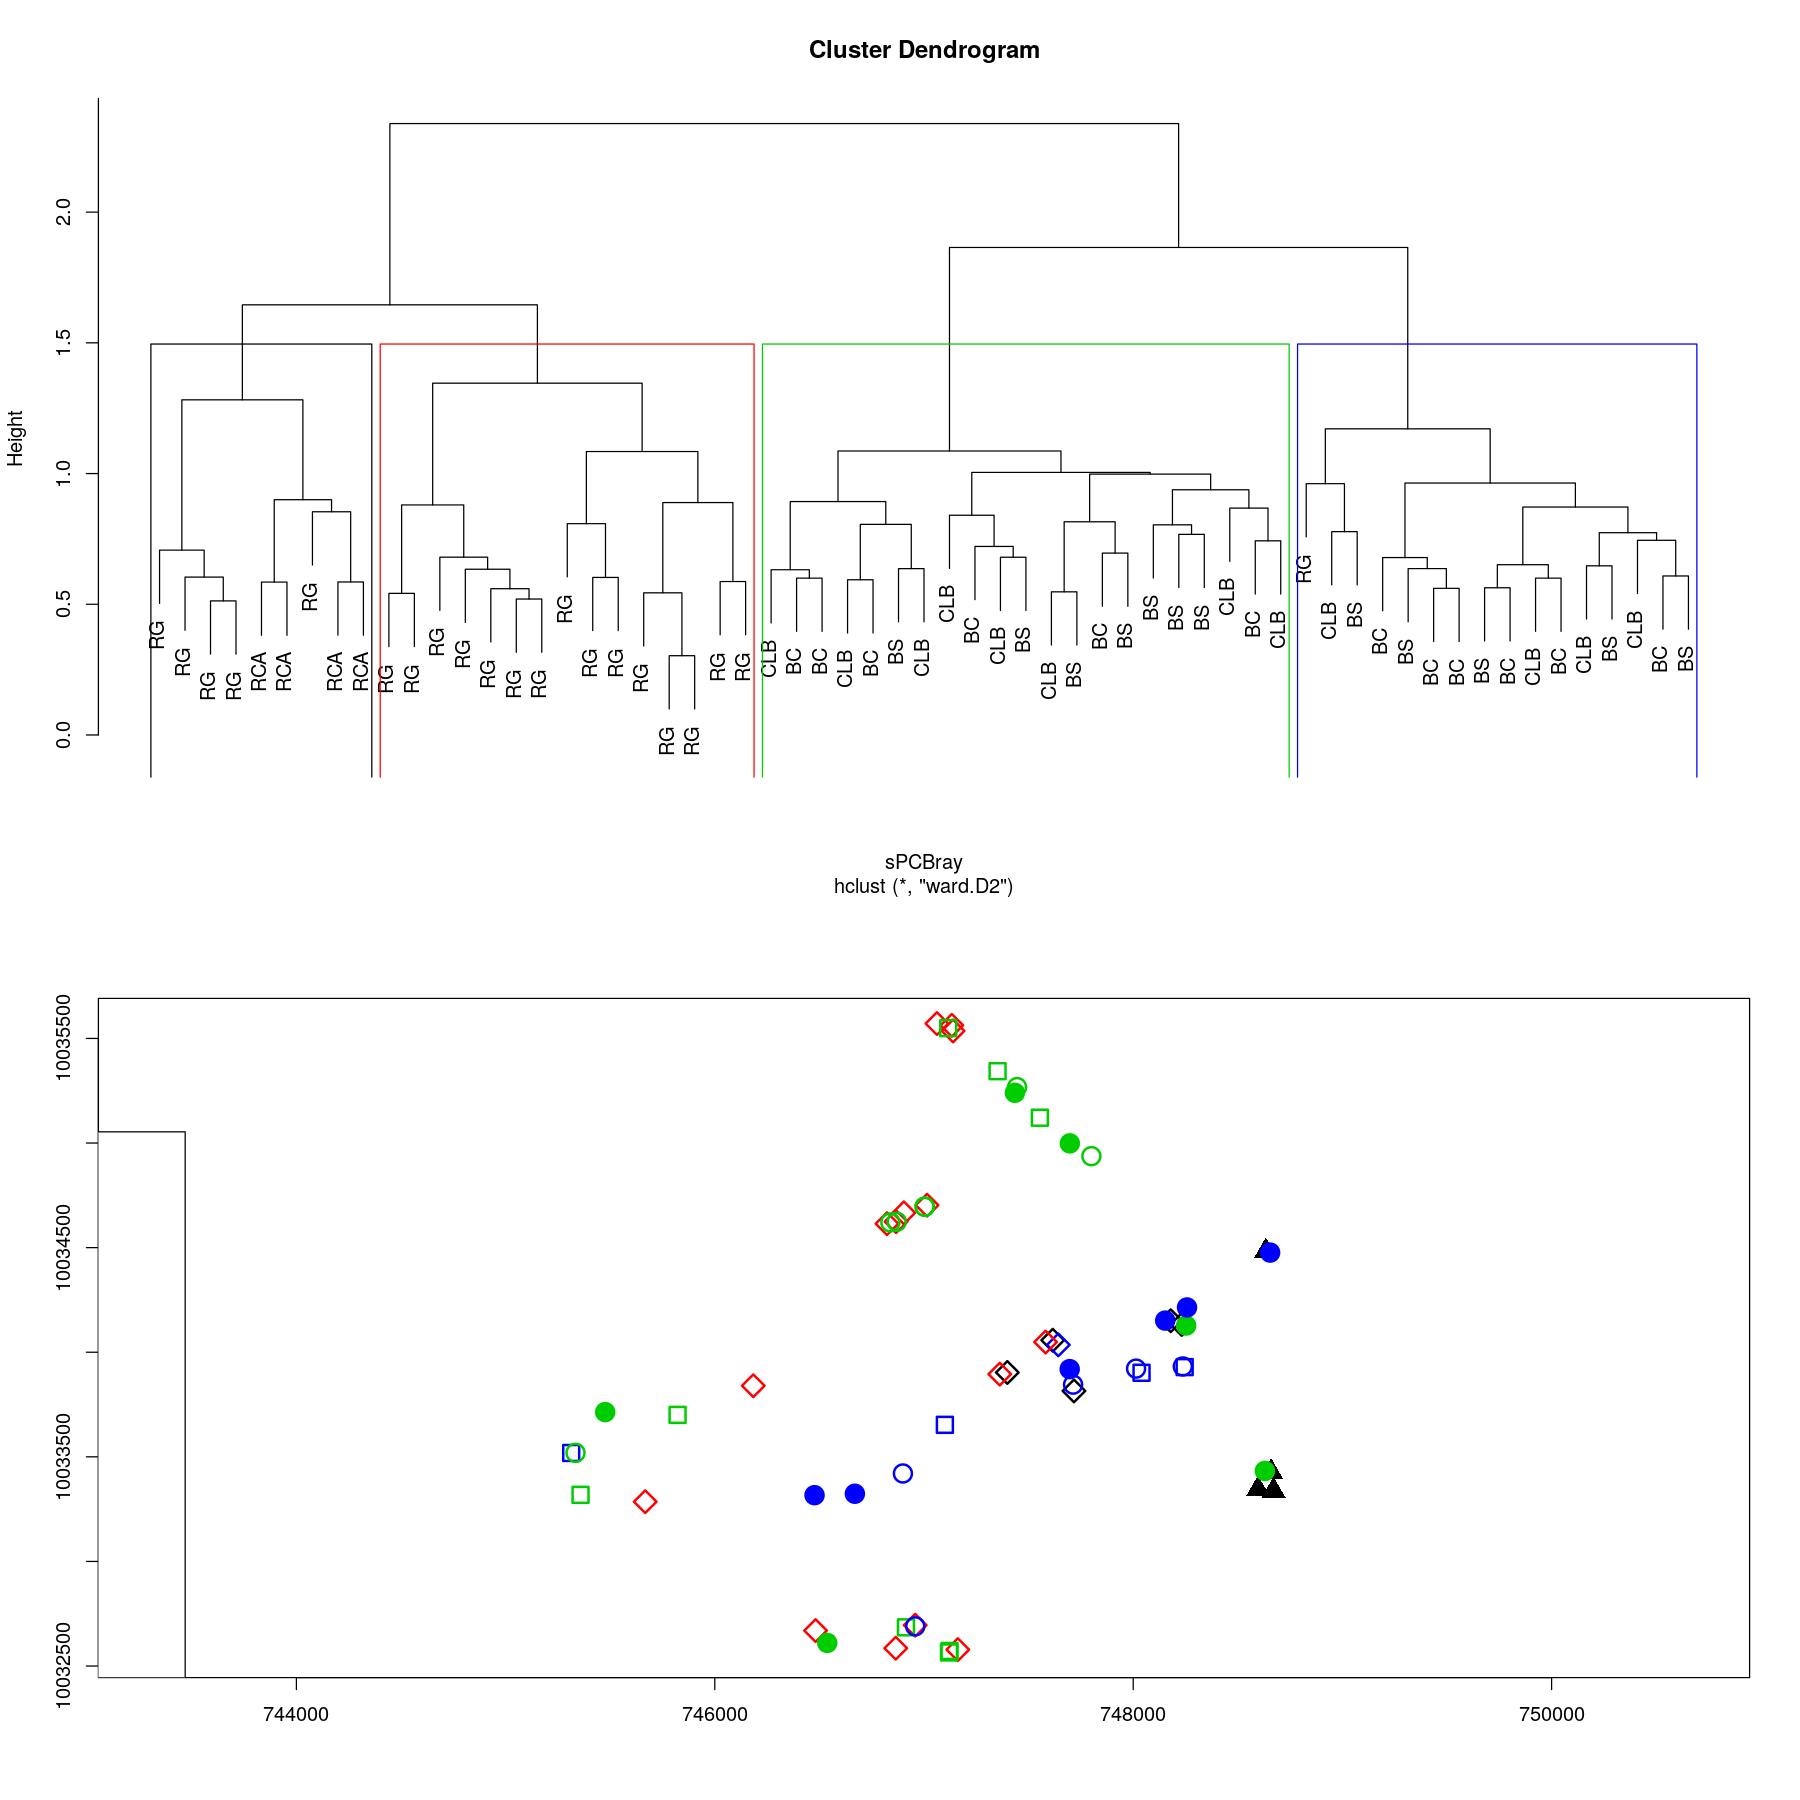

In [23]:
options(repr.plot.width=15, repr.plot.height=15)
k <- 4 ## number of groups 
bb <- makeClustMap(sPC.ward, k=k, labels='hab')
legend('bottomright',
    legend=c('BC', 'BS', 'CLB', 'RCA', 'RG'),
    pch=c(19, 21, 22, 17, 23)
)

legend('bottomleft',
    legend=1:k,
    pch=c(15),
    col=1:k,
    title='ClusterGroup')


The jupyter plotter isn't really handling that well. PNG's:

 <img src="hclust4groups.png" width="1000">

Just for reference, this is the tree with unique Plot/subplot identifiers:

<img src='hclust_4groups_PsubP.png' width="1000">

In the tree above, the RCA plots are again by themselves in a group, with a few RG plots. The closest "relative" of these RCA plots is a section that contains the majority of the RG plots, group 2, in red. The other two groups (groups 3/green and 4/blue) form a major branch, and contain most of the secondary and closed forest, and the natural gaps. Interesting that the gaps cluster in with the forest so distinctly from the regen sites. The split in the forest groups, 3 & 4, may be showing the difference between riparian and upland sites, but needs a closer look. 

The second graph is a physical map, reflecting the distances among the points. 

[back to top](#contents)

<a id='DEGmap'></a>

### Physical Map

Let's put an elevation and water (rivers and stream) map under these plots. We'll use python here, as the geopandas library is way easier to use than the whole mess of R geospatial packages. 

#### Cleaning the raw data
The first step is a bit of cleanup from the data I've received from Ana. Location information for all 30m-diameter plots was given to me from Ana in a file called "GPSpointsCedros.xls". For the points to make sense from this file, I had to exchange the N and E columns, I think they were switched/mislabeled, and that the easting column is off by 10^7 meters. They appear to be in a UTM CRS, but not the zone 17S that I typically use for the LC area. Swapping the N/E columns and adding 10^7 meters seems to fix the problem. Following this, I imported the spreadsheet into QGIS for a visual check, and exported it as a geojson, which we can turn into a geopanda here:


In [20]:
anaPt = gpd.read_file('GIS/ana30meterPlots.geojson')
## some weird column names, fix them:
anaPt.rename(columns={
                    "No Hoja/Page":"hoja",
                    "Ubicacion/Ubication":"ubicacion",
                    "Sitio/Site":"sitio",
                    "Habitat":"habitat",
                    "Parcela/Plot":"parcela",
                    "Subparcela  /Subplot": "subparcela",
                    "Fecha/Date": "fecha",
                    "Elevation": "elevation",
                    }, inplace=True)

## don't think we need these:
anaPt.drop(['hoja','ubicacion'], axis=1, inplace=True)

## add in a PsubP column as a unique plot identifier like we've been using elsewhere
PsubPseries = anaPt.parcela.astype('str') + "." + anaPt.subparcela.astype('str')
anaPt.insert(5,"PsubP", PsubPseries.astype('float'))

## our cluster info is here:
cGroup = pd.read_csv("cGroup.csv")
## add this cluster info in
anaPt = anaPt.merge(cGroup, on="PsubP")

## make a vector for coloring the clustering results:
cdik={
1:"k",
2:"r",
3:"g",
4:"b"
}
anaPt['clustCols'] = [ cdik[i] for i in anaPt.gr ]
## set the habitat symbol
msym_dik={
'BC':'o',
'BS':'p',
'CLB':'s',
'RCA':'^',
'RG':'D',
}
anaPt['habSyms'] = [ msym_dik[i] for i in anaPt.habitat ]

anaPt

,sitio,habitat,parcela,subparcela,fecha,PsubP,N,E,elevation,geometry,gr,clustCols,habSyms
0,1,RG,1,1,8/11/2005,1.1,10034127,748246,1425,POINT (748246.000 10034127.000),1,k,D
1,1,RG,1,2,8/11/2005,1.2,10034158,748207,1337,POINT (748207.000 10034158.000),1,k,D
2,1,RG,1,3,8/26/2005,1.3,10033810,747728,1256,POINT (747728.000 10033810.000),1,k,D
3,1,RG,1,4,8/29/2005,1.4,10034057,747598,1340,POINT (747598.000 10034057.000),1,k,D
4,1,RG,1,5,8/29/2005,1.5,10033898,747376,1337,POINT (747376.000 10033898.000),1,k,D
5,1,RCA,2,1,8/13/2005,2.1,10033330,748670,1189,POINT (748670.000 10033330.000),1,k,^
6,1,RCA,2,2,8/13/2005,2.2,10033337,748610,1200,POINT (748610.000 10033337.000),1,k,^
7,1,RCA,2,3,8/15/2005,2.3,10033427,748648,1201,POINT (748648.000 10033427.000),1,k,^
8,1,RCA,2,4,8/15/2005,2.4,10034474,748661,1226,POINT (748661.000 10034474.000),1,k,^
9,1,RG,10,1,8/27/2005,10.1,10034029,747618,1332,POINT (747618.000 10034029.000),4,b,D


That seems to work alright. Now we can use this as our point layer for the plots. But we can get a few other layers that I have handy for los Cedros also - a DEG (elevation map), a polygon on LC boundaries, and a map of streams and rivers of los Cedros.

In [24]:
lcPoly = gpd.read_file('GIS/lcPoly.geojson')
hydro = gpd.read_file('GIS/lcRiversStreams.geojson')
deg = rasterio.open("GIS/anaPlotDEG.tif")

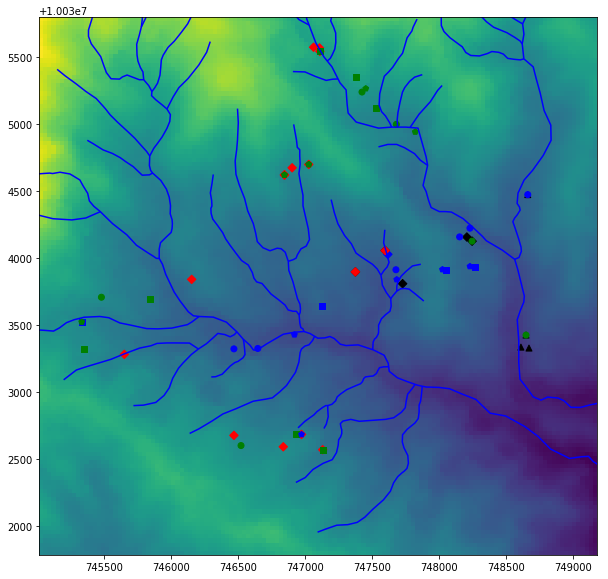

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
for i in anaPt.habitat.unique():
    anaPtI = anaPt[anaPt['habitat'] ==  i].reset_index()
    anaPtI.plot(color=anaPtI.clustCols,
                marker=anaPtI.habSyms[0],
                ax=ax)
hydro.plot(color='Blue', ax=ax)
rasterio.plot.show(deg, ax=ax)

That's nice but we're losing some points, they are stacked right on top of each other in some places. We can jitter them a little bit:

In [27]:
def jitt(x,σ=10):
    ''' returns a jittered value using normal dist '''
    xJit = x + random.gauss(0, σ)
    return(xJit)

def jitCoords(gdf, σ=10):
    ''' jitters a geopanda df. Amount of jitter is set 
        with the 'σ' parameter'''
    aa=copy.deepcopy(gdf)
    xx = aa.geometry.x.apply(jitt, args=(σ,)).astype('int')
    yy = aa.geometry.y.apply(jitt, args=(σ,)).astype('int')
    aa.geometry = gpd.points_from_xy(xx,yy)
    return(aa)

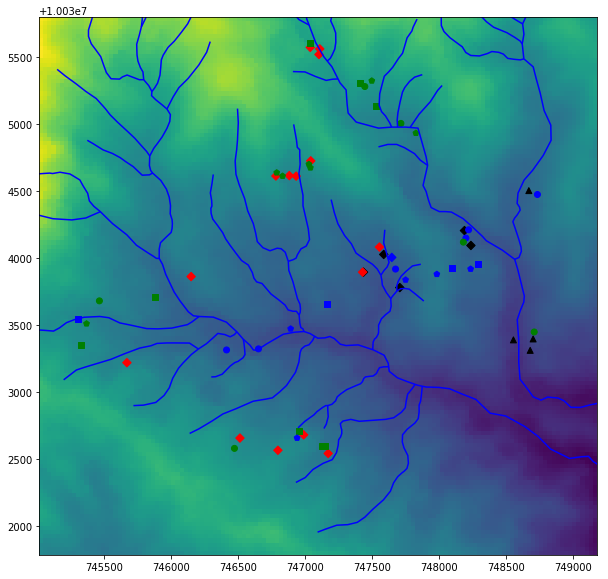

In [30]:
jit = 40
anaPtJitt = jitCoords(anaPt, σ=jit)
fig, ax = plt.subplots(figsize=(10,10))
for i in anaPtJitt.habitat.unique():
    anaPtI = anaPtJitt[anaPtJitt['habitat'] ==  i].reset_index()
    anaPtI.plot(color=anaPtI.clustCols,
                marker=anaPtI.habSyms[0],
                ax=ax)

hydro.plot(color='Blue', ax=ax)
#paths.plot(color='red', ax=ax)
deg = rasterio.open("GIS/anaPlotDEG.tif")
rasterio.plot.show(deg, ax=ax)


Will make a legend separately, can't seem to make it work in python or R easily right now. Colors correspond to the hierarchical clustering results graphic above: 

1=black  
2=red  
3=green  
4=blue  

Shapes correspond to the succession state/habitat: 

BC = circles  
BS = pentagons  
CLB = squares  
RCA = triangles  
RG = diamonds  

[back to top](#contents)

<a id='indSpp'></a>

### Indicator species analysis

Let's look to see if we pick up any obvious indicator species for either the habitat types (clearing, bosque secondario, regenerating finca sites, etc) or for our clustering results. Back in R:

In [1]:
library(indicspecies)

Loading required package: permute



In [11]:
## our community matrix...
comM <- read.csv('subParcelComm.csv')
rownames(comM) <- comM$PsubP

## general plant observation dataframe
specObs <- read.csv('specObs.csv', row.names=1)
## make a PsubP/habitat dataframe:
habs <- unique(specObs[,c('PsubP','habitat')])
rownames(habs) <- NULL

## and our cluster groups:
cldf <- read.csv('cGroup.csv')

## make sure they are the same order
habs <- habs[order(habs$PsubP),]
comM <- comM[order(comM$PsubP),]
cldf <- cldf[order(cldf$PsubP),]
all(habs$PsubP == comM$PsubP)
all(habs$PsubP == rownames(comM))
all(cldf$PsubP == rownames(comM))

## now we can make a vector of our habs dataframe:
habsV <- habs$habitat
clV <- cldf$gr

## clean up extra column of com matrix, careful with this
comM <- comM[,-1] ## get rid of PsubP

[1] TRUE

[1] TRUE

[1] TRUE

In [12]:
habIndSpp <- multipatt(comM, habsV, func = 'r.g', control=how(nperm=9999))

clustIndSpp <- multipatt(comM, clV, func = 'r.g', control=how(nperm=9999))

In [13]:
summary(habIndSpp)


 Multilevel pattern analysis
 ---------------------------

 Association function: r.g
 Significance level (alpha): 0.05

 Total number of species: 343
 Selected number of species: 24 
 Number of species associated to 1 group: 20 
 Number of species associated to 2 groups: 3 
 Number of species associated to 3 groups: 1 
 Number of species associated to 4 groups: 0 

 List of species associated to each combination: 

 Group BC  #sps.  1 
                              stat p.value  
Moraceae.Pseudolmedia.rigida 0.423  0.0332 *

 Group BS  #sps.  3 
                                    stat p.value  
Rubiaceae.Psychotria.paeonia       0.478  0.0153 *
Lauraceae.Persea.pseudofasciculata 0.432  0.0351 *
Myrtaceae.Myrcia.aff..aliena       0.425  0.0337 *

 Group CLB  #sps.  1 
                                    stat p.value  
Lauraceae.Endlicheria.cf..chalisea 0.431  0.0315 *

 Group RCA  #sps.  11 
                                          stat p.value    
Boraginaceae.Cordia.colombiana    

In [14]:
summary(clustIndSpp)


 Multilevel pattern analysis
 ---------------------------

 Association function: r.g
 Significance level (alpha): 0.05

 Total number of species: 343
 Selected number of species: 48 
 Number of species associated to 1 group: 32 
 Number of species associated to 2 groups: 16 
 Number of species associated to 3 groups: 0 

 List of species associated to each combination: 

 Group 1  #sps.  9 
                                         stat p.value    
Boraginaceae.Cordia.colombiana          0.661  0.0001 ***
Melastomataceae.Meriania.tomentosa      0.641  0.0001 ***
Actinidaceae.Saurauia.sp..1             0.545  0.0002 ***
Cyatheaceae.Cyathea.halonata            0.458  0.0037 ** 
Fab.Caesalpiniaceae.Senna.dariensis     0.449  0.0054 ** 
Moraceae.Ficus.caldasiana               0.420  0.0210 *  
Melastomataceae.Leandra.subseriata      0.370  0.0167 *  
Melastomataceae.Miconia.aff..brevitheca 0.368  0.0221 *  
Staphyleaceae.Turpinia.occidentalis     0.346  0.0425 *  

 Group 2  #sps.  5 
   

[back to top](#contents)

<a id='mantel'></a>

### Mantel tests

Let's check the estimations of spatial autocorrelation in the plant community with mantel correlograms/tests.

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6


Attaching package: ‘ecodist’


The following object is masked from ‘package:vegan’:

    mantel




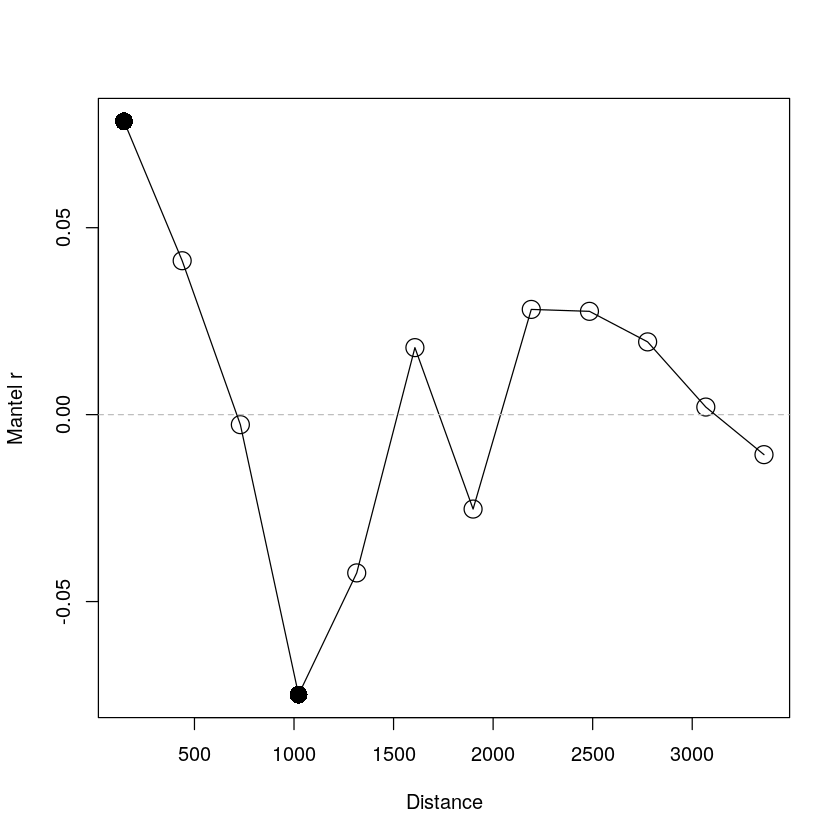

In [1]:
library('vegan')
library('ecodist')

## make the distance matrix 
aa <- read.csv('subParcelSpatial.csv', row.names="PsubP")[,-1]
physdist <- vegdist(aa, method='euclidean')
## make the community dissimilarity matrix
bb <- read.csv('subParcelComm.csv', row.names="PsubP")
braydist <- vegdist(bb, method='bray')
## correlogram
cgram <- mgram(braydist, physdist) ## correlogram object
plot(cgram)
global_mant_test <- mantel(braydist ~ physdist, nperm = 10000) ## overall test


In [2]:
global_mant_test

mantelr        pval1        pval2        pval3    llim.2.5%   ulim.97.5% 
 0.007898217  0.389900000  0.610200000  0.802200000 -0.015213108  0.033265643

Globally, not picking up a lot of autocorrelation here. Not surprising given the high beta-diversity of the system. Let's break it down into individual habitat types (BC, RG, etc):

In [3]:
getDists <- function(comfile, physfile='subParcelSpatial.csv'){
    comM <- read.csv(comfile, row.names=1)
    comM <- comM[order(as.numeric((rownames(comM)))),]
    spM <- read.csv(physfile, row.names='PsubP')[,-1]
    spM <- spM[rownames(spM)%in%rownames(comM),]
    spM <- spM[order(as.numeric((rownames(comM)))),]
    if(all(rownames(spM) == rownames(comM))){
        physdist <- vegdist(spM, method='euclidean')
        braydist <- vegdist(comM, method='bray')
        return(list(braydist, physdist))
        }
    else{print("something doesn't fit right")}
    }

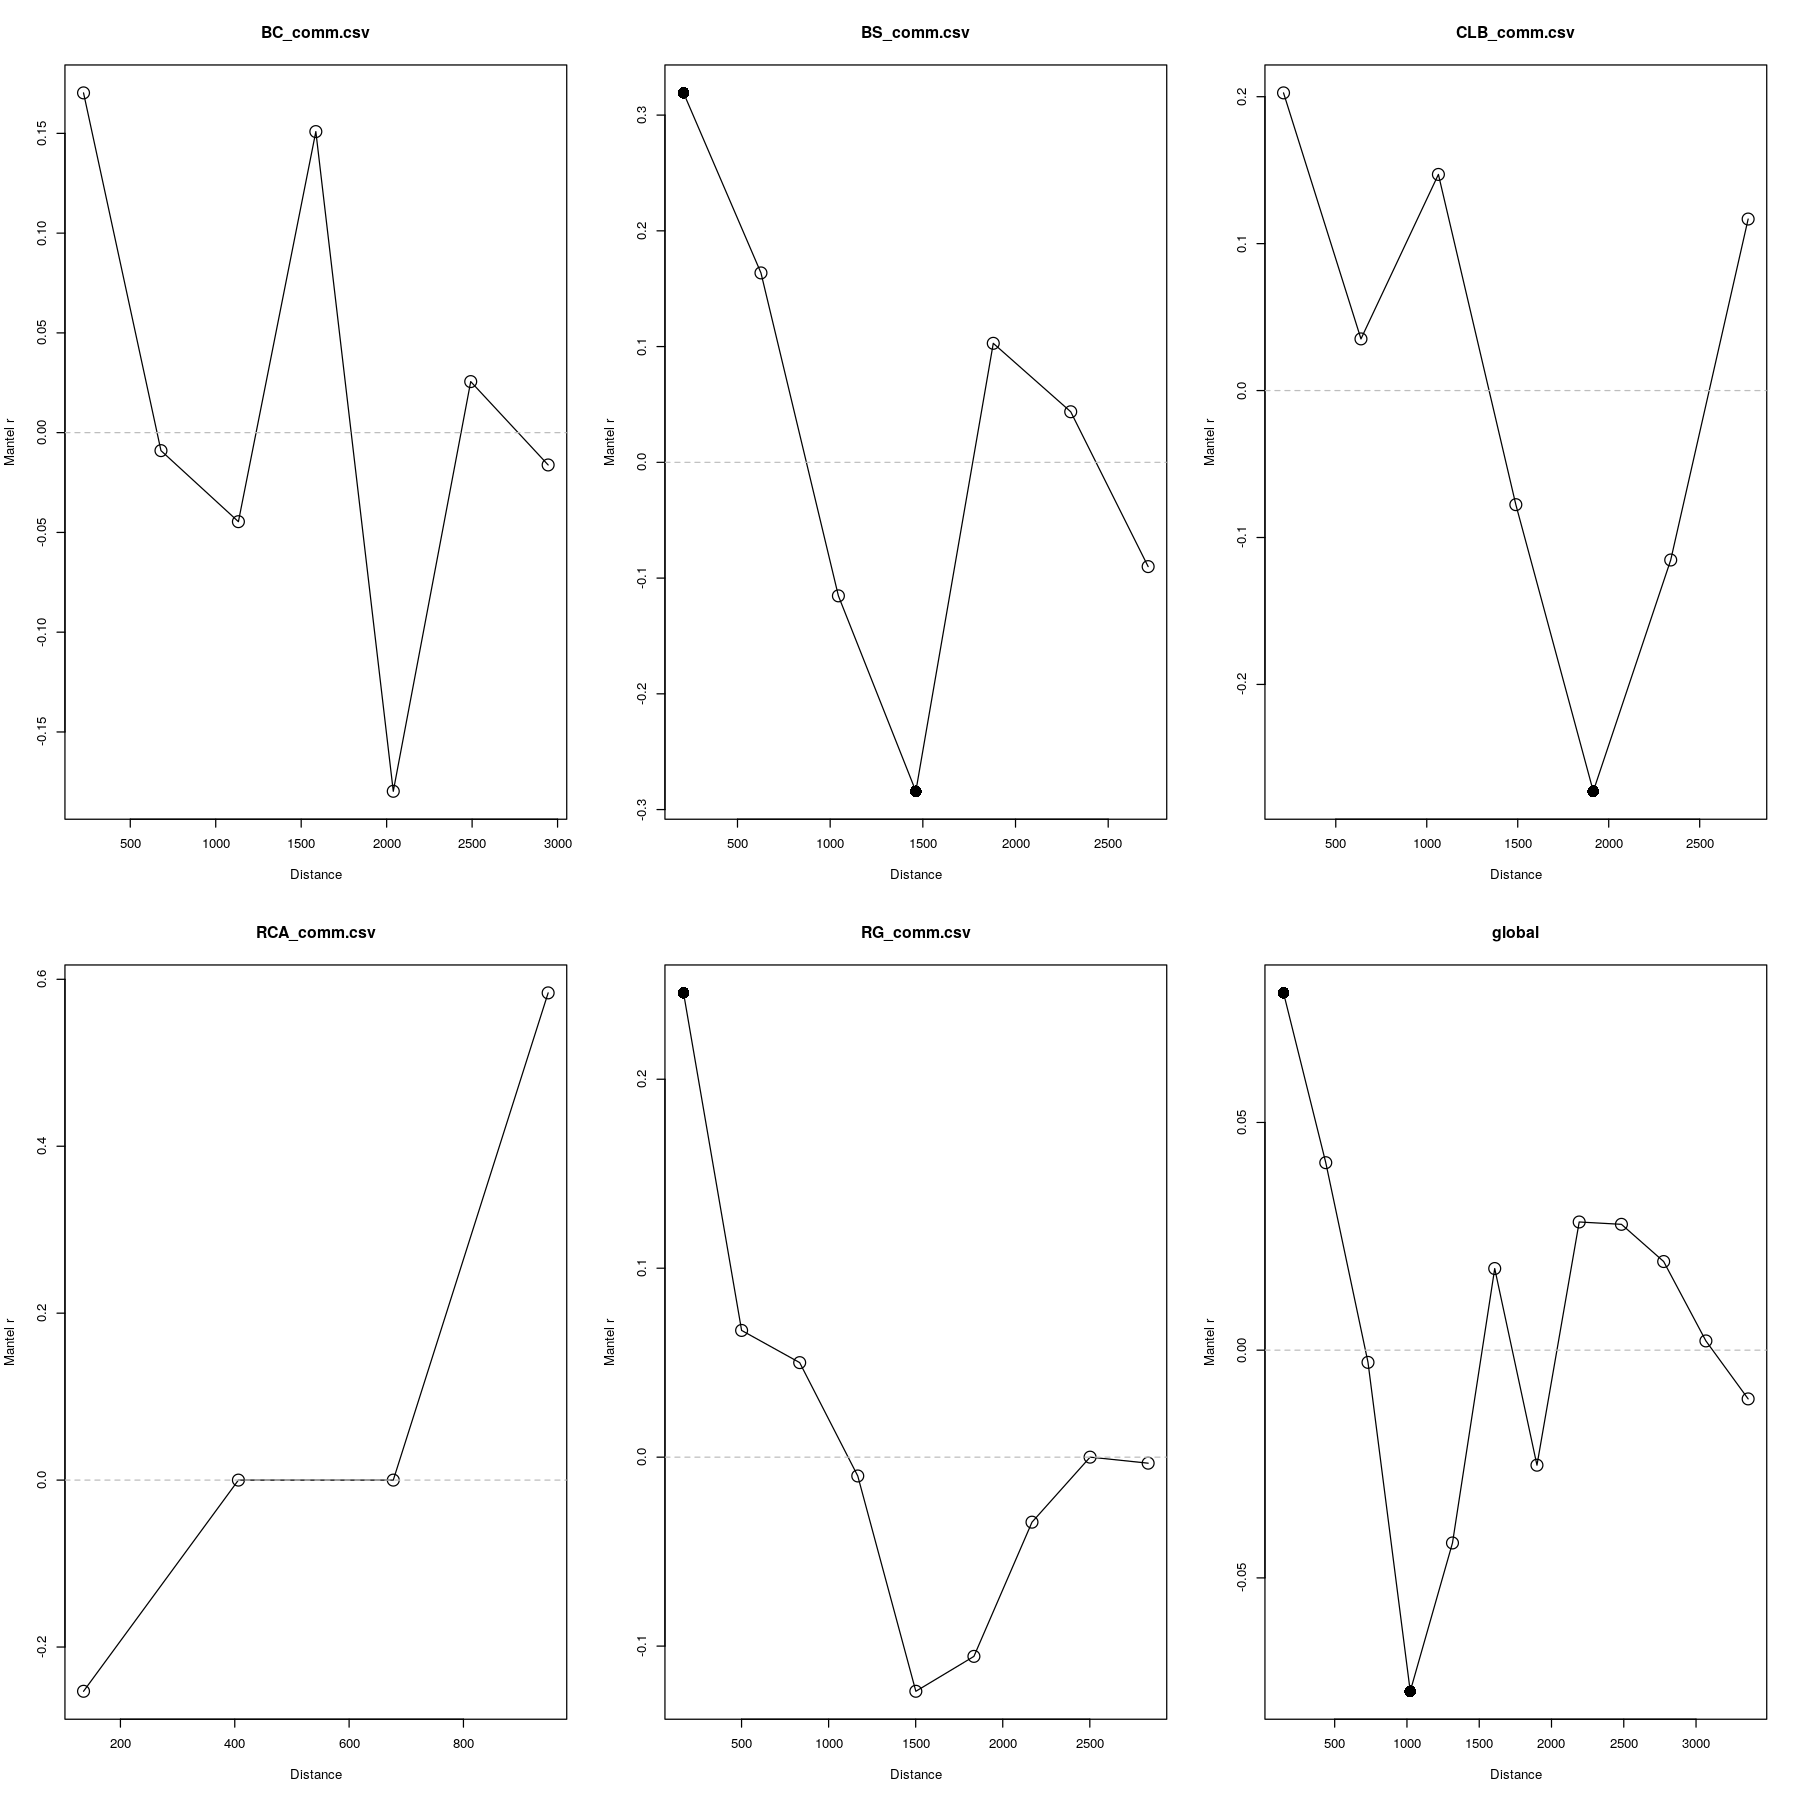

In [12]:
options(repr.plot.width=15, repr.plot.height=15)
comms <- c('BC_comm.csv', 'BS_comm.csv', 'CLB_comm.csv', 'RCA_comm.csv', 'RG_comm.csv')
## start df
all_mant_test  <- global_mant_test
## test individually
par(mfrow=c(2,3))
for (i in 1:length(comms)){
    dists.i <- getDists(comms[i])
    cgram.i <- mgram(dists.i[[1]], dists.i[[2]]) ## correlogram object
    plot(cgram.i, main = comms[i] )
    mant_test.i <- mantel(dists.i[[1]] ~ dists.i[[2]], nperm = 10000) ## overall test
    all_mant_test <- rbind(mant_test.i, all_mant_test)
}
plot(cgram, main = "global" )
rownames(all_mant_test) <- c(rev(comms), 'global')

In [13]:
all_mant_test

,mantelr,pval1,pval2,pval3,llim.2.5%,ulim.97.5%
RG_comm.csv,0.192332375,0.0211,0.9790,0.0316,0.11039008,0.29735271
RCA_comm.csv,-0.201140938,0.8338,0.2066,0.4565,-0.80958753,0.98205204
CLB_comm.csv,0.143543591,0.1217,0.8784,0.2307,0.02246878,0.31708738
BS_comm.csv,0.205281054,0.0516,0.9485,0.0846,0.11310191,0.32479166
BC_comm.csv,0.140049320,0.1373,0.8628,0.2749,0.01201468,0.28353844
global,0.007898217,0.3899,0.6102,0.8022,-0.01521311,0.03326564


It's the RCA plots that confuse the global correlation, I think. They have a negative trend in autocorrelation - there is a homogenizing effect somewhere on them, plots that are far away are more similar that you would expect. The old forest types (BS, BC, and CLB) have a pretty similar trajectory:

[1] TRUE

[1] TRUE

[1] TRUE

mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.12648406 0.01000000 0.99010000 0.01250000 0.04870707 0.19176666

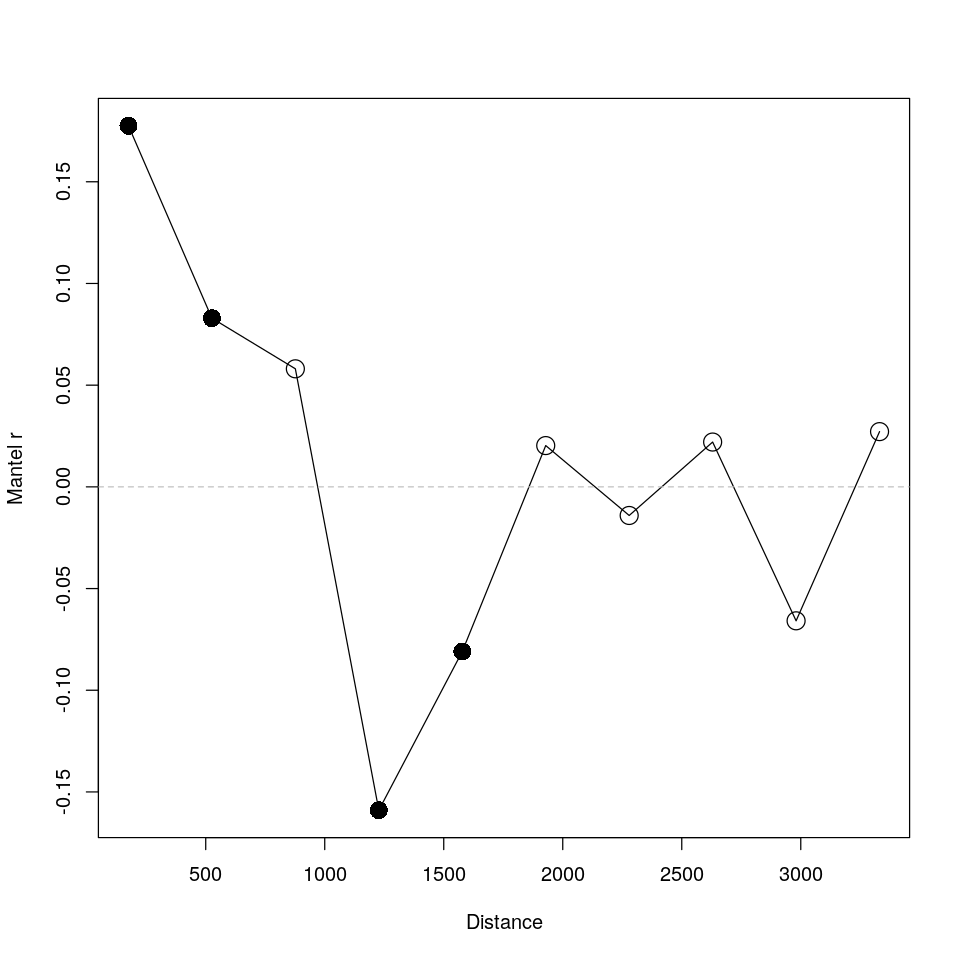

In [18]:
options(repr.plot.width=8, repr.plot.height=8)

specObs <- read.csv('specObs.csv', row.names=1)
## make a PsubP/habitat dataframe:
habs <- unique(specObs[,c('PsubP','habitat')])
## order by site
habs <- habs[order(habs$Psub),]
rownames(habs) <- NULL
## ge
PsubPoldForest <- habs$habitat != 'RCA' & habs$habitat != 'RG'

aa <- read.csv('subParcelSpatial.csv')[-1]
aa <- aa[order(aa$PsubP),]
rownames(aa) <- NULL
bb <- read.csv('subParcelComm.csv')
bb <- bb[order(bb$PsubP),]
rownames(bb) <- NULL
all(habs$PsubP == aa$PsubP)
all(habs$PsubP == bb$PsubP)
## subset these:
aa <- aa[PsubPoldForest,]
bb <- bb[PsubPoldForest,]
all(rownames(aa) == rownames(bb))

## make dist objects
physdist <- vegdist(aa, method='euclidean')
braydist <- vegdist(bb, method='bray')
cgram <- mgram(braydist, physdist) ## correlogram object
plot(cgram)
mant_test <- mantel(braydist ~ physdist, nperm = 10000) ## overall test

In [19]:
mant_test

mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.12648406 0.01000000 0.99010000 0.01250000 0.04870707 0.19176666

Clear signs of positive autocorrelation until ~1000 m. Following this, we again find some sort of homogenizing effect in 1000-1500 m, then no spatial signature. I'd guess the negative autocorrelation has to do with the layout of the plots: many of the plots are clustered, and the clusters are ~1000 m apart. But we can try to look a little closer with PCNMs. 

[back to top](#contents)